In [366]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

In [736]:
#データの読み込み
item_categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")
sample = pd.read_csv("sample_submission.csv")
sales_train = pd.read_csv("sales_train.csv")

In [633]:
#学習データの変数を確認
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [634]:
items.shape

(22170, 3)

In [635]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [745]:
test.head()

,ID,shop_id,item_id,item_category_id,date_block_num,item_cnt_day,item_price
0,0,5,5037,19,34,0,NA
1,1,5,5320,55,34,0,NA
2,2,5,5233,19,34,0,NA
3,3,5,5232,23,34,0,NA
4,4,5,5268,20,34,0,NA


In [637]:
sample.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [638]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [738]:
sales_train["shop_id"].value_counts().sort_index()

0       9857
1       5678
2      25991
3      25532
4      38242
5      38179
6      82663
7      58076
8       3412
9       3751
10     21397
11       499
12     34694
13     17824
14     36979
15     59511
16     52734
17     22950
18     53227
19     63911
20      1792
21     58133
22     45434
23      6963
24     53032
25    186104
26     53910
27    105366
28    142234
29     49225
30     50860
31    235636
32      7947
33      5027
34      5752
35     58445
36       306
37     39638
38     46013
39     13440
40      4257
41     41967
42    109253
43     39282
44     39530
45     35891
46     66321
47     56695
48     21612
49     15849
50     65173
51     44433
52     43502
53     52921
54    143480
55     34769
56     69573
57    117428
58     71441
59     42108
Name: shop_id, dtype: int64

In [739]:
# テーブルをjoin
sales_train = sales_train.merge(items,how="left").merge(item_categories,how="left").merge(shops,how="left")
test = test.merge(items,how="left").drop("item_name",axis=1)

In [741]:
# 店舗ごとの月次データに変換する
sales_train_shop_monthly = sales_train.groupby(["shop_id","item_id","date_block_num"],as_index=False).sum()

In [742]:
#sales_train_shop_monthly.duplicated(subset=['shop_id', 'item_id'])
sales_train_shop_monthly.head(5)

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_id
0,0,30,1,2385.0,31.0,360
1,0,31,1,3038.0,11.0,259
2,0,32,0,884.0,6.0,160
3,0,32,1,1547.0,10.0,280
4,0,33,0,1041.0,3.0,111


In [743]:
sales_train_shop_monthly.shape

(1609124, 6)

In [744]:
test["date_block_num"] = 34
test["item_cnt_day"] = 0
test["item_price"] = "NA"
test.shape

(214200, 7)

In [746]:
# testデータとマージする

all_data = pd.concat([sales_train_shop_monthly,test],axis=0,ignore_index=True)
all_data

/Users/shin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


,ID,date_block_num,item_category_id,item_cnt_day,item_id,item_price,shop_id
0,NaN,1,360,31.0,30,2385,0
1,NaN,1,259,11.0,31,3038,0
2,NaN,0,160,6.0,32,884,0
3,NaN,1,280,10.0,32,1547,0
4,NaN,0,111,3.0,33,1041,0
5,NaN,1,111,3.0,33,1041,0
6,NaN,0,40,1.0,35,247,0
7,NaN,1,440,14.0,35,2717,0
8,NaN,1,37,1.0,36,357,0
9,NaN,1,57,1.0,40,127,0


In [747]:
#3ヶ月移動平均線を追加
all_data["average_3month"] = all_data.groupby(['shop_id', 'item_id'])['item_cnt_day'].apply(lambda x: x.rolling(window=3,min_periods=1).mean().shift())


KeyboardInterrupt: 

In [748]:
all_data

,ID,date_block_num,item_category_id,item_cnt_day,item_id,item_price,shop_id
0,NaN,1,360,31.0,30,2385,0
1,NaN,1,259,11.0,31,3038,0
2,NaN,0,160,6.0,32,884,0
3,NaN,1,280,10.0,32,1547,0
4,NaN,0,111,3.0,33,1041,0
5,NaN,1,111,3.0,33,1041,0
6,NaN,0,40,1.0,35,247,0
7,NaN,1,440,14.0,35,2717,0
8,NaN,1,37,1.0,36,357,0
9,NaN,1,57,1.0,40,127,0


In [752]:
#店舗リストを作成
train_shop_list = sales_train_shop_monthly["shop_id"].unique()
test_shop_list = test["shop_id"].unique()

print(train_shop_list.shape)
print(test_shop_list.shape)

(60,)
(42,)


In [753]:
#商品リストを作成
train_item_list = sales_train_shop_monthly["item_id"].unique()
test_item_list = test["item_id"].unique()

print(train_item_list.shape)
print(test_item_list.shape)

(21807,)
(5100,)


In [ ]:
# 月×店舗×商品のテーブルを作成
df_all = []
for month in range(34):
    for shop in all_data["shop_id"].unique():
        for item in all_data["item_id"].unique():
            df_all.append([month,shop,item])
            
df_all = pd.DataFrame(df_all,columns=["date_block_num","shop_id","item_id"])
df_all

In [705]:
#集計用に全店舗合計のテーブルを用意する
df_shop_all = all_data.groupby("date_block_num").sum()
df_shop_all.loc[35] = 0
df_shop_all

,item_category_id,item_cnt_day,item_id,shop_id,average_3month
date_block_num,,,,,
0,4574740,131479.0,689570083,1849038,0.000000
1,4319172,128090.0,635621832,1709162,83896.000000
2,4777604,147142.0,683889872,2096214,95204.500000
3,3804157,107190.0,584278228,1825649,113820.166667
4,3694879,106970.0,562835164,1778818,106562.833333
5,4033579,125381.0,600690782,1866568,106339.666667
6,4088854,116966.0,637275515,1931676,113380.500000
7,4146799,125291.0,621568420,1920966,110133.500000
8,3731098,133332.0,546905803,1715803,107462.500000


## 探索的データ分析

In [380]:
#目的変数の分布を確認
target =sales_train_shop_monthly["item_cnt_day"]

In [381]:
#歪度と尖度を計算
print("歪度: %f" % target.skew())
print("尖度: %f" % target.kurt())

歪度: 69.407579
尖度: 8797.066398


In [711]:
#店舗数を確認
len(all_data["shop_id"].unique())

60

In [708]:
#商品数を確認
len(all_data["item_id"].unique())

22170

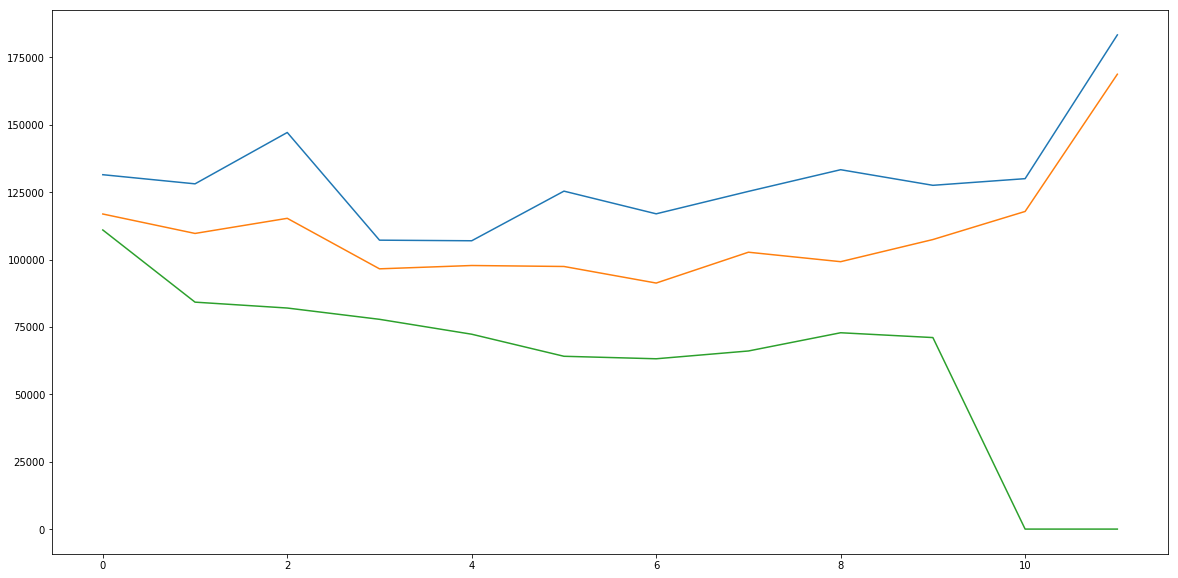

In [622]:
# 時系列の合計売上個数の推移を表示
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
plt.figure(figsize=(20,10))
plt.plot(x,df_shop_all["item_cnt_day"].loc[:11])
plt.plot(x,df_shop_all["item_cnt_day"].loc[12:23])
plt.plot(x,df_shop_all["item_cnt_day"].loc[24:35])

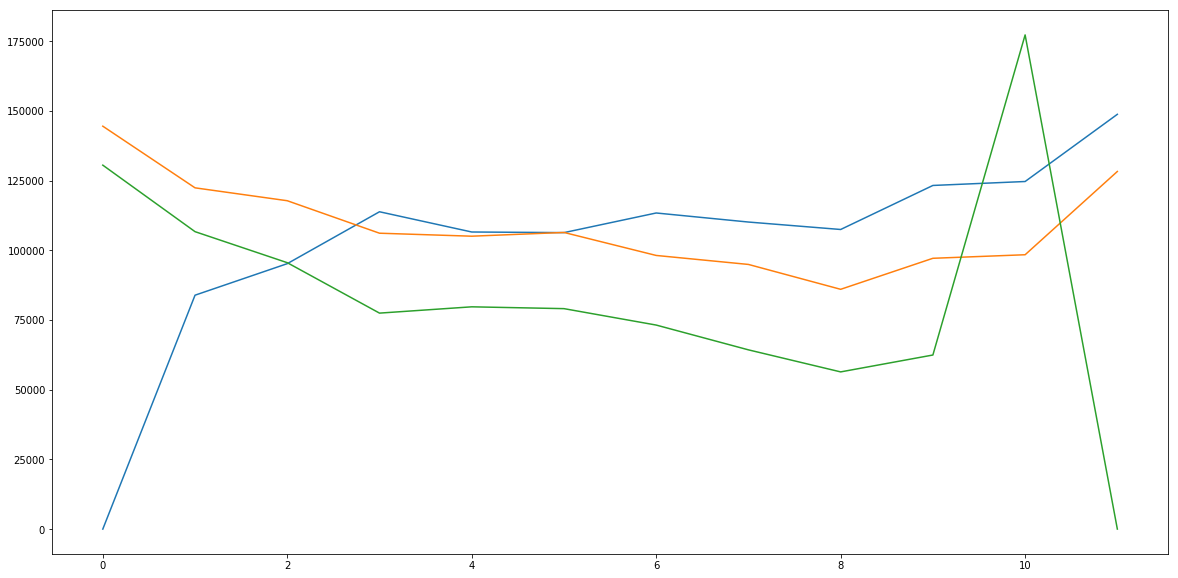

In [706]:
# 時系列の３ヶ月平均売上個数の推移を表示
x = np.array([0,1,2,3,4,5,6,7,8,9,10,11])
plt.figure(figsize=(20,10))
plt.plot(x,df_shop_all["average_3month"].loc[:11])
plt.plot(x,df_shop_all["average_3month"].loc[12:23])
plt.plot(x,df_shop_all["average_3month"].loc[24:35])

Text(0, 0.5, 'item_cnt_day')

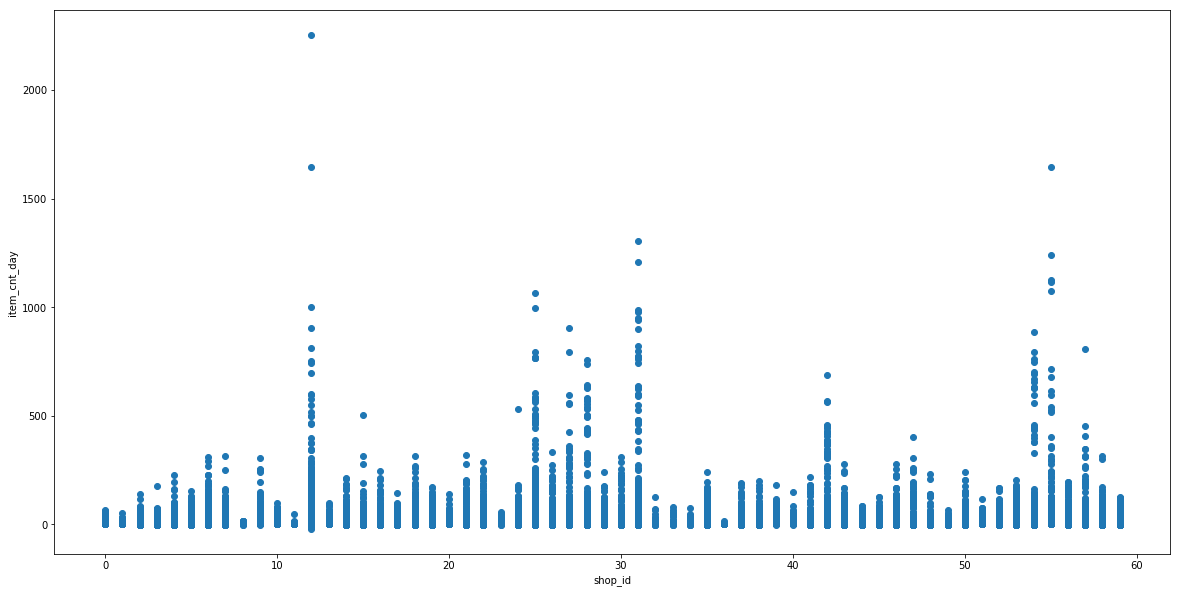

In [382]:
#店舗ごとの分布を確認
plt.figure(figsize=(20, 10))
plt.scatter(sales_train_shop_monthly["shop_id"],sales_train_shop_monthly["item_cnt_day"])
plt.xlabel("shop_id")
plt.ylabel("item_cnt_day")

Text(0, 0.5, 'item_cnt_day')

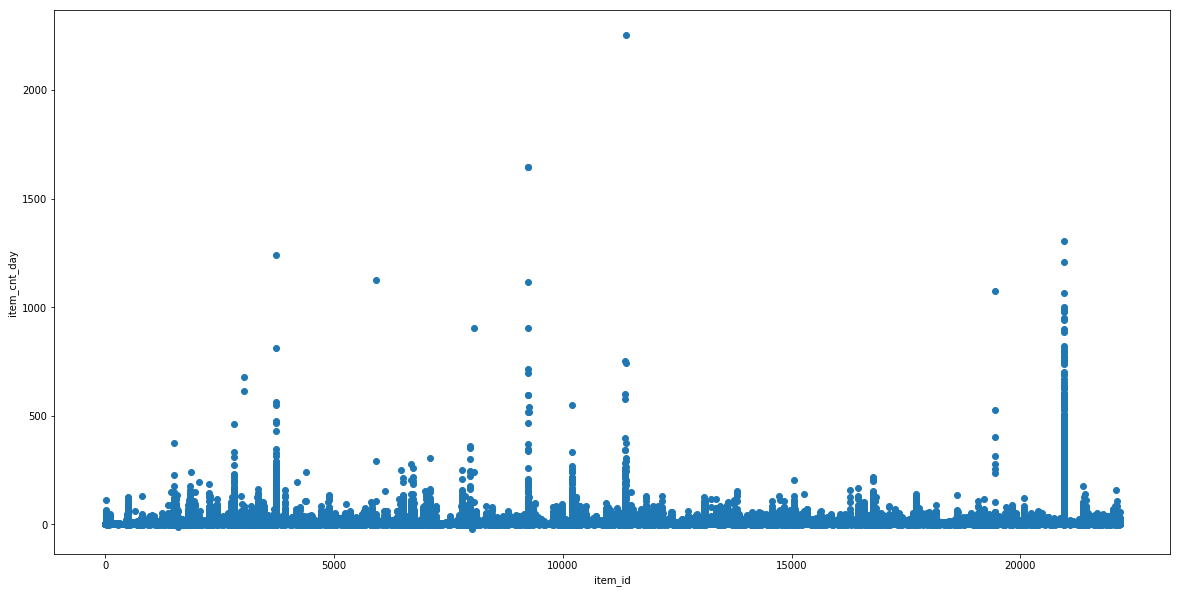

In [383]:
#商品ごとの分布を確認
plt.figure(figsize=(20, 10))
plt.scatter(sales_train_shop_monthly["item_id"],sales_train_shop_monthly["item_cnt_day"])
plt.xlabel("item_id")
plt.ylabel("item_cnt_day")

Text(0, 0.5, 'item_cnt_day')

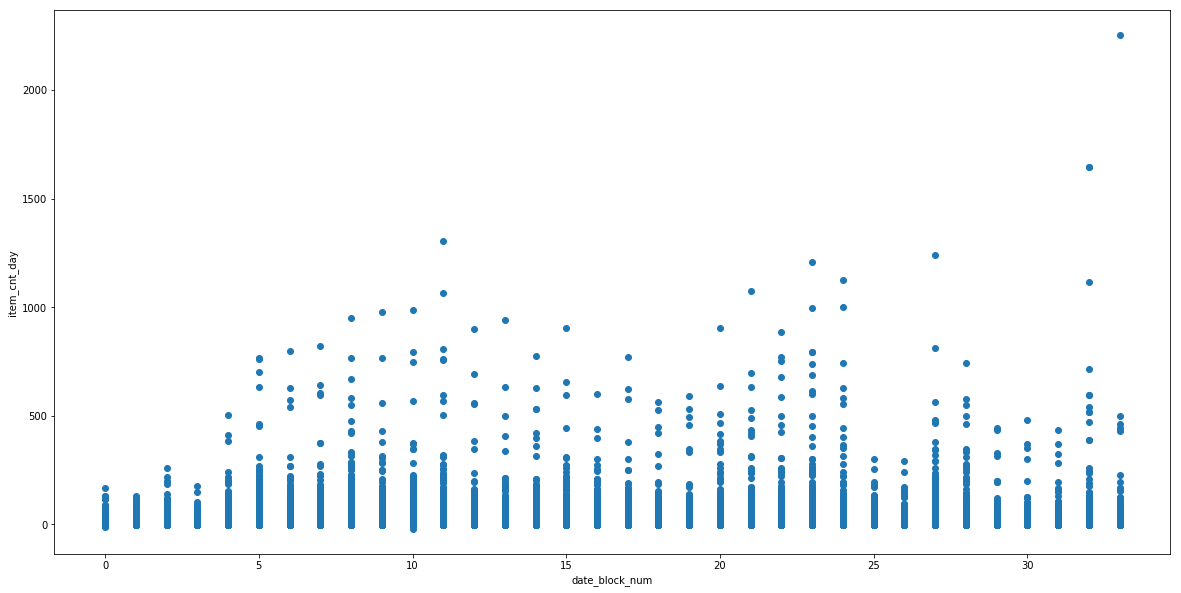

In [364]:
#時系列の売上個数をカウント
plt.figure(figsize=(20, 10))
plt.scatter(sales_train_shop_monthly["date_block_num"],sales_train_shop_monthly["item_cnt_day"])
plt.xlabel("date_block_num")
plt.ylabel("item_cnt_day")

In [583]:
#外れ値を除外
df = sales_train_shop_monthly.sort_values(by="item_cnt_day").reset_index(drop=True)

#2.5%タイルの位置
q025 = round(len(sales_train_shop_monthly)*0.025)

#97.5%タイルの位置
q975 = round(len(sales_train_shop_monthly)*0.975)

#上下2.5%を除いて抽出
df2 = df.iloc[q025:q975,:]
df2

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_id,average_3month
40228,41,4132,8,899.000000,1.0,75,NaN
40229,41,4127,5,1190.000000,1.0,75,1.000000
40230,41,4127,0,1190.000000,1.0,75,NaN
40231,41,4178,14,1590.000000,1.0,75,8.666667
40232,41,3971,26,299.000000,1.0,55,2.666667
40233,41,4067,20,299.000000,1.0,55,NaN
40234,41,4058,10,1899.000000,1.0,23,NaN
40235,41,4032,5,1298.700000,1.0,22,NaN
40236,41,4029,23,69.300000,1.0,30,1.000000
40237,41,4029,19,69.300000,1.0,30,1.000000


In [724]:
#3ヶ月移動平均線を追加
df2["average_3month"] = df2.groupby(['shop_id', 'item_id'])['item_cnt_day'].apply(lambda x: x.rolling(window=3,min_periods=1).mean().shift())

KeyboardInterrupt: 

In [584]:
#月でソートする
df2 = df2.sort_values(by="date_block_num").reset_index(drop=True)

In [585]:
df2

,shop_id,item_id,date_block_num,item_price,item_cnt_day,item_category_id,average_3month
0,12,11776,0,399.000000,1.0,40,NaN
1,54,19565,0,199.000000,1.0,40,NaN
2,8,16678,0,199.000000,1.0,40,NaN
3,54,5636,0,4779.833333,4.0,4,NaN
4,2,11389,0,899.000000,1.0,19,NaN
5,8,16662,0,149.000000,1.0,40,NaN
6,25,14182,0,399.000000,1.0,43,NaN
7,25,12617,0,499.000000,1.0,37,NaN
8,25,14183,0,449.000000,1.0,43,NaN
9,12,686,0,1500.000000,1.0,73,NaN


In [586]:
# validationの設定
# めんどいので単純にhold-outで最後の１ヶ月分をvalidとする

valid = df2[df2["date_block_num"]==33]
train = df2[df2["date_block_num"] < 33]

train_x = train.drop(["item_cnt_day","item_price"], axis=1)
train_y = train["item_cnt_day"]
valid_x = valid.drop(["item_cnt_day","item_price"], axis=1)
valid_y = valid["item_cnt_day"]

In [587]:
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(1498916, 5)
(1498916,)
(29752, 5)
(29752,)


In [588]:
# とりあえずlightgbmにぶっこんでみる

#データセットを生成する
lgb_train = lgb.Dataset(train_x, train_y)
lgb_eval = lgb.Dataset(valid_x, valid_y, reference=lgb_train)

#LightGBM のハイパーパラメータ
lgb_params = {
        'objective': 'regression',
        'num_leaves': 10,
        'learning_rate': 0.01, 
        'n_estimators': 300,
        'max_bin': 200, 
        'bagging_fraction': 0.75,
        'bagging_freq': 5, 
        'bagging_seed': 7,
        'feature_fraction': 0.2,
        'feature_fraction_seed': 7,
        'verbose': -1,
        'metric': 'rmse'
    }

lgb_evals_result = {}

# 上記のパラメータでモデルを学習する
lightgbm = lgb.train(
                    lgb_params, 
                    lgb_train, 
                    valid_sets=lgb_eval,
                    evals_result=lgb_evals_result,
                )

ypred = lightgbm.predict(train_x)

/Users/shin/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1.30424
[2]	valid_0's rmse: 1.29555
[3]	valid_0's rmse: 1.29546
[4]	valid_0's rmse: 1.29536
[5]	valid_0's rmse: 1.29515
[6]	valid_0's rmse: 1.28667
[7]	valid_0's rmse: 1.28438
[8]	valid_0's rmse: 1.27608
[9]	valid_0's rmse: 1.26784
[10]	valid_0's rmse: 1.25975
[11]	valid_0's rmse: 1.25967
[12]	valid_0's rmse: 1.25952
[13]	valid_0's rmse: 1.25151
[14]	valid_0's rmse: 1.25132
[15]	valid_0's rmse: 1.24348
[16]	valid_0's rmse: 1.2413
[17]	valid_0's rmse: 1.23917
[18]	valid_0's rmse: 1.23142
[19]	valid_0's rmse: 1.2237
[20]	valid_0's rmse: 1.21605
[21]	valid_0's rmse: 1.216
[22]	valid_0's rmse: 1.21395
[23]	valid_0's rmse: 1.2066
[24]	valid_0's rmse: 1.20646
[25]	valid_0's rmse: 1.19915
[26]	valid_0's rmse: 1.19717
[27]	valid_0's rmse: 1.197
[28]	valid_0's rmse: 1.18982
[29]	valid_0's rmse: 1.18789
[30]	valid_0's rmse: 1.18069
[31]	valid_0's rmse: 1.17375
[32]	valid_0's rmse: 1.17369
[33]	valid_0's rmse: 1.16688
[34]	valid_0's rmse: 1.16683
[35]	valid_0's rmse: 1.15993
[

[276]	valid_0's rmse: 0.784048
[277]	valid_0's rmse: 0.784052
[278]	valid_0's rmse: 0.783979
[279]	valid_0's rmse: 0.783983
[280]	valid_0's rmse: 0.782635
[281]	valid_0's rmse: 0.782526
[282]	valid_0's rmse: 0.782474
[283]	valid_0's rmse: 0.782422
[284]	valid_0's rmse: 0.782332
[285]	valid_0's rmse: 0.782284
[286]	valid_0's rmse: 0.782201
[287]	valid_0's rmse: 0.782134
[288]	valid_0's rmse: 0.782069
[289]	valid_0's rmse: 0.78074
[290]	valid_0's rmse: 0.780744
[291]	valid_0's rmse: 0.779495
[292]	valid_0's rmse: 0.779431
[293]	valid_0's rmse: 0.77828
[294]	valid_0's rmse: 0.77818
[295]	valid_0's rmse: 0.778085
[296]	valid_0's rmse: 0.776917
[297]	valid_0's rmse: 0.776846
[298]	valid_0's rmse: 0.776831
[299]	valid_0's rmse: 0.775554
[300]	valid_0's rmse: 0.774409


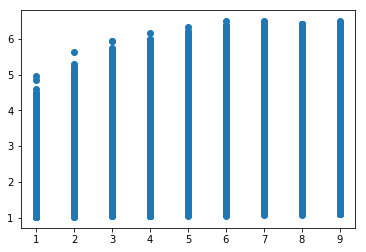

In [589]:
#trainデータとの合致度を可視化
plt.subplots_adjust(wspace=0.4)
plt.scatter(train_y,lightgbm.predict(train_x))

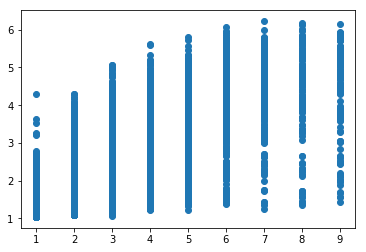

In [590]:
#validデータとの合致度を可視化
plt.scatter(valid_y,lightgbm.predict(valid_x))

## Xgboost

In [623]:
#特徴量と目的変数をxgboostのデータ構造に変換する
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x,label=valid_y)

/Users/shin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/shin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [624]:
#パラメータを指定してGBDT
num_round = 200
evallist = [(dvalid, 'eval'), (dtrain, 'train')]

evals_result = {}

#パラメータ
param = {
            'max_depth': 3,
            'eta': 0.01,
            'objective': 'reg:squarederror',
}

#学習の実行
bst = xgb.train(
                        param, dtrain,
                        num_round,
                        evallist,
                        evals_result=evals_result,
                        # 一定ラウンド回しても改善が見込めない場合は学習を打ち切る
                        early_stopping_rounds=100
                        )

[0]	eval-rmse:1.72388	train-rmse:1.82133
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 100 rounds.
[1]	eval-rmse:1.70983	train-rmse:1.80722
[2]	eval-rmse:1.69595	train-rmse:1.79333
[3]	eval-rmse:1.68223	train-rmse:1.77829
[4]	eval-rmse:1.66867	train-rmse:1.76502
[5]	eval-rmse:1.6553	train-rmse:1.7485
[6]	eval-rmse:1.64209	train-rmse:1.73523
[7]	eval-rmse:1.62899	train-rmse:1.72216
[8]	eval-rmse:1.616	train-rmse:1.70944
[9]	eval-rmse:1.60312	train-rmse:1.69615
[10]	eval-rmse:1.59054	train-rmse:1.68335
[11]	eval-rmse:1.57798	train-rmse:1.67136
[12]	eval-rmse:1.56586	train-rmse:1.65892
[13]	eval-rmse:1.55372	train-rmse:1.64718
[14]	eval-rmse:1.54193	train-rmse:1.63351
[15]	eval-rmse:1.53024	train-rmse:1.62215
[16]	eval-rmse:1.51848	train-rmse:1.60896
[17]	eval-rmse:1.50708	train-rmse:1.59724
[18]	eval-rmse:1.49589	train-rmse:1.58597
[19]	eval-rmse:1.48449	train-rmse:1.57442
[20]	eval-rmse:1.47351	train

[187]	eval-rmse:0.773801	train-rmse:0.796426
[188]	eval-rmse:0.772918	train-rmse:0.795401
[189]	eval-rmse:0.772164	train-rmse:0.794385
[190]	eval-rmse:0.771339	train-rmse:0.793366
[191]	eval-rmse:0.770461	train-rmse:0.792276
[192]	eval-rmse:0.769635	train-rmse:0.791312
[193]	eval-rmse:0.768839	train-rmse:0.790195
[194]	eval-rmse:0.768066	train-rmse:0.789241
[195]	eval-rmse:0.767214	train-rmse:0.788191
[196]	eval-rmse:0.766449	train-rmse:0.787186
[197]	eval-rmse:0.765701	train-rmse:0.786164
[198]	eval-rmse:0.764944	train-rmse:0.78528
[199]	eval-rmse:0.764216	train-rmse:0.784261


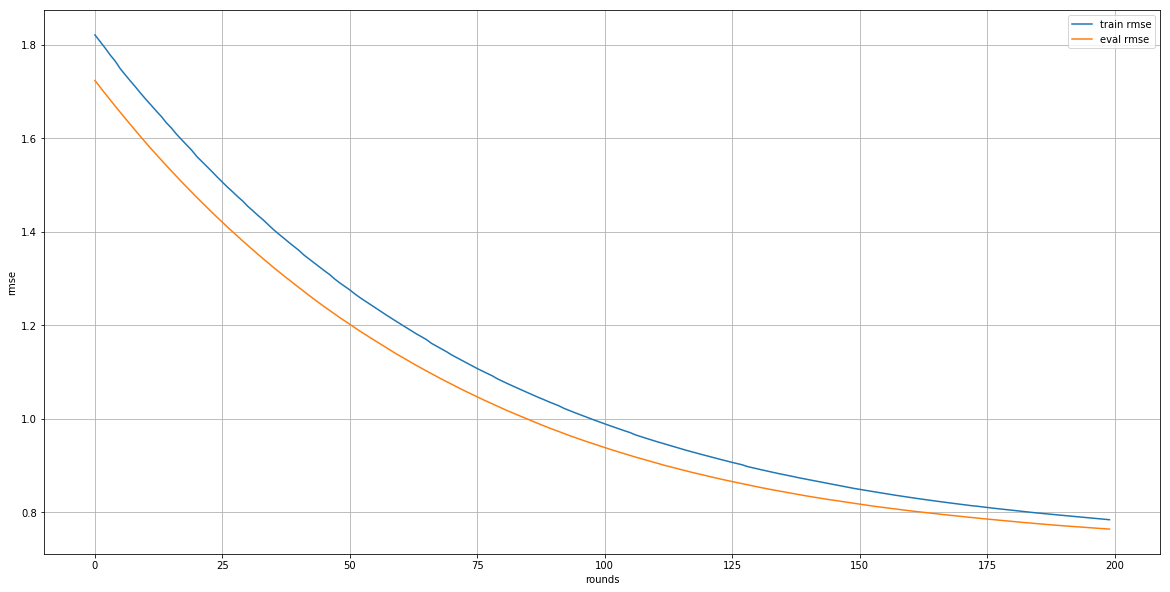

In [625]:
#学習曲線を可視化する
plt.figure(figsize=(20, 10))
train_metric = evals_result['train']['rmse']
plt.plot(train_metric, label='train rmse')
eval_metric = evals_result['eval']['rmse']
plt.plot(eval_metric, label='eval rmse')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('rmse')
plt.show()

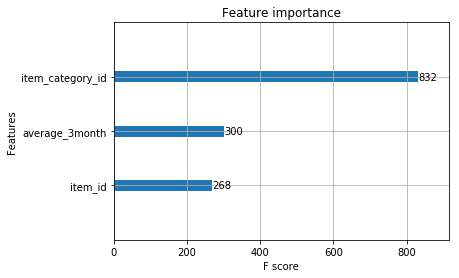

In [626]:
#特徴量ごとの重要度を可視化する
ax = xgb.plot_importance(bst)
fig = ax.figure

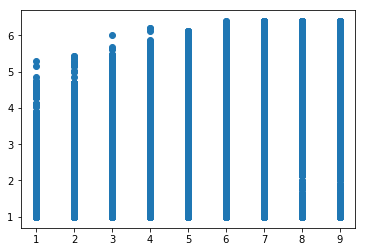

In [629]:
plt.subplots_adjust(wspace=0.4)
plt.scatter(train_y,bst.predict(dtrain))

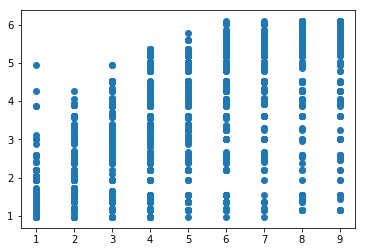

In [453]:
plt.subplots_adjust(wspace=0.4)
plt.scatter(valid_y,bst.predict(dvalid))

In [454]:
#testデータで実行
lightgbm.predict(test)

array([0.95872361, 1.05155488, 0.95872361, ..., 1.05155488, 1.05565823,
       1.05565823])

In [455]:
# 提出用ファイルの作成
my_submission = pd.DataFrame()
my_submission["Id"] = sample["ID"]
my_submission["item_cnt_month"] =lightgbm.predict(test)

# you could use any filename. We choose submission here
my_submission.to_csv('submission.csv', index=False)

In [456]:
my_submission

,Id,item_cnt_month
0,0,0.958724
1,1,1.051555
2,2,0.958724
3,3,0.958724
4,4,0.958724
5,5,0.958724
6,6,0.958724
7,7,1.051555
8,8,1.051555
9,9,0.958724
